# Principal Component Analysis

In this notebook, I explore the concept of principal component analysis using the singular value decomposition method.

The data being used is the United States arrests dataset `USArrests` from 1973 (https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/USArrests). The data is ordered by U.S. state. The observables are:

1. Murder:  Murder arrests (per 100,000)
2. Assault: Assault arrests (per 100,000)
3. UrbanPop: Percent urban population
4. Rape: Rape arrests (per 100,000)


In [1]:
from pathlib import Path

from bokeh.models import LinearColorMapper, BasicTicker, ColorBar, LabelSet
from bokeh.plotting import figure, show, ColumnDataSource, save, output_file
import bokeh.io as bio
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.linalg import svd, eig


I will be making interactive plots using the Bokeh library. The plots are also saved in the `pca_plots` directory

In [2]:
bio.output_notebook()

Loading BokehJS ...

Let's load the data and examine it.

In [3]:
usarrests_path = Path("usarrests.csv")

usarrests_converters = {
    "State": str,
    "Murder": np.float32,
    "Assault": np.float32,
    "UrbanPop": np.float32,
    "Rape": np.float32
}

usarrests_df = pd.read_csv(
    usarrests_path,
    header=0,
    converters=usarrests_converters
)

In [4]:
usarrests_df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236.0,58.0,21.200001
1,Alaska,10.0,263.0,48.0,44.500000
2,Arizona,8.1,294.0,80.0,31.000000
3,Arkansas,8.8,190.0,50.0,19.500000
4,California,9.0,276.0,91.0,40.599998


Let's remove the "State" column and pair-plot the data

In [5]:
usarrests_data_df: pd.DataFrame = usarrests_df.iloc[:, 1:]

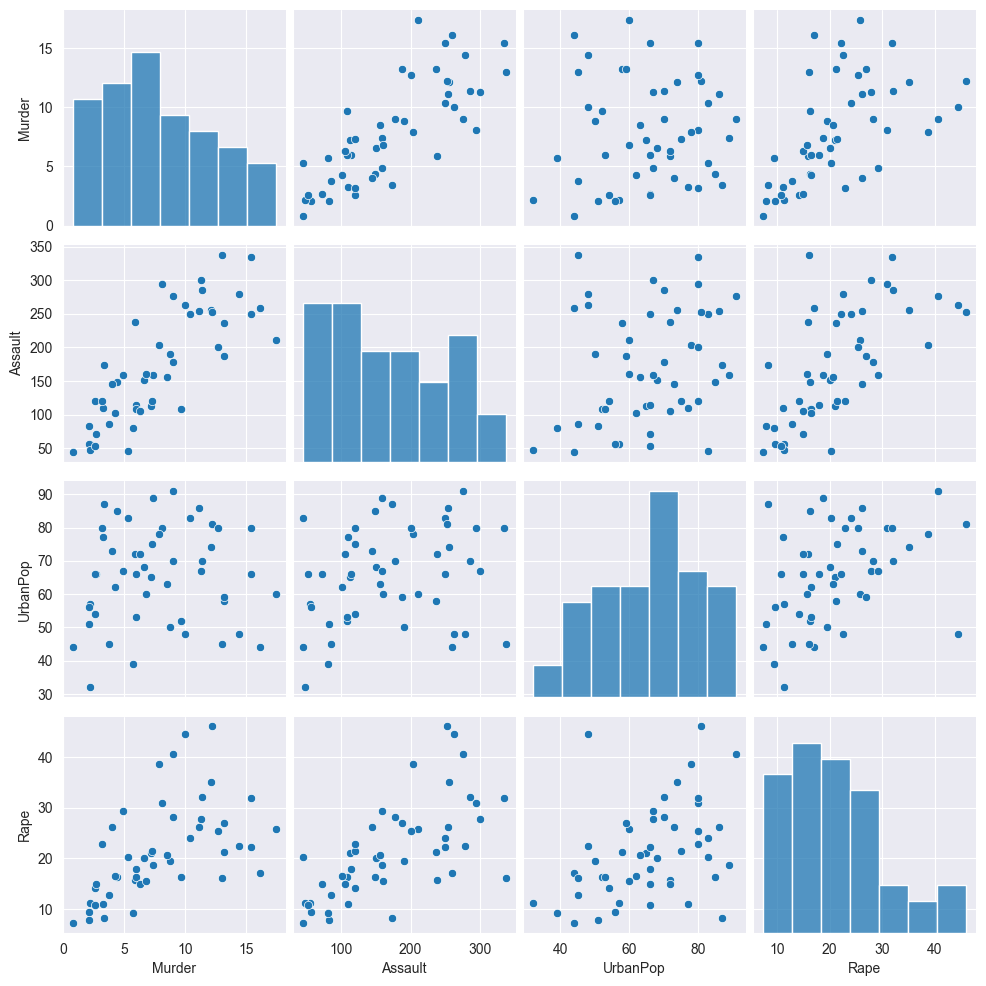

In [6]:
sns.pairplot(usarrests_data_df)

We can see that most of the data is highly correlated. We should not make inferences from the data about any "true" rates as each state may have different definitions and reporting standards. Rape is especially difficult as it is one of the more difficult crimes to report and make an arrest.

We see that murder, assault, and rape are highly, positively correlated, especially murder and assault. This means we should expect that PCA will be able to reduce the dimensionality of the problem.

In [7]:
data_mat: np.ndarray = usarrests_data_df.to_numpy(np.float32)
data_mat.shape

(50, 4)

We need to normalize the data.

With the help of NumPy's broadcast feature, we can calculate the column-
wise mean and standard deviation to construct a new data matrix. This is
acheived using the `axis=0` option which means that the aggregate is
performed on the zero (0) "row" axis.

In [8]:
means: np.ndarray = np.mean(data_mat, axis=0)
std_devs: np.ndarray = np.std(data_mat, axis=0)
data_norm_mat: np.ndarray = (data_mat - means) / std_devs

In [9]:
data_norm_mat

array([[ 1.2551792 ,  0.7907873 , -0.5261952 , -0.00345111],
       [ 0.51301855,  1.1180598 , -1.2240669 ,  2.509424  ],
       [ 0.07236073,  1.493817  ,  1.0091223 ,  1.0534662 ],
       [ 0.23470834,  0.233212  , -1.0844926 , -0.18679401],
       [ 0.28109333,  1.2756354 ,  1.776781  ,  2.0888138 ],
       [ 0.02597562,  0.40290883,  0.86954796,  1.8839015 ],
       [-1.0408803 , -0.73648417,  0.79976076, -1.0927233 ],
       [-0.43787482,  0.8150297 ,  0.45082498, -0.58583426],
       [ 1.7654146 ,  1.9907863 ,  1.0091223 ,  1.1505301 ],
       [ 2.229265  ,  0.48775724, -0.38662094,  0.49265283],
       [-0.57702994, -1.5122411 ,  1.2184837 , -0.11129984],
       [-1.2032281 , -0.61527216, -0.80534387, -0.7583923 ],
       [ 0.6057885 ,  0.9483629 ,  1.2184837 ,  0.2985252 ],
       [-0.13637209, -0.70012057, -0.03768513, -0.02502094],
       [-1.2959982 , -1.3910291 , -0.5959824 , -1.0711535 ],
       [-0.4146823 , -0.67587817,  0.03210203, -0.3485671 ],
       [ 0.44344094, -0.

Let's perform the SVD where


$$
\begin{align}
    M &= U \Sigma W^T
\end{align}
$$

where $\Sigma$ is n-by-p rectangular diagonal matrix of positive numbers, $\Sigma$ is he singular values of $M$, $U$ is an n-by-n matrix, the columns of which are orthogonal unit vectors of length n called the left singular vectors of $M$; and $W$ is a p-by-p whose columns are orthogonal unit vectors of length p and called the right singular vectors of $M$.

We interpret the $W$ matrix as the PCA change-of-basis transformation.


In [10]:
u_mat, s_mat, w_t_mat = svd(a=data_norm_mat)

In [11]:
u_mat.shape, s_mat.shape, w_t_mat.shape

((50, 50), (4,), (4, 4))

Looks like SciPy takes a different approach to SVD where the middle item of the output tuple is a row-vector.

In [12]:
s_mat

array([11.136072 ,  7.034789 ,  4.2223406,  2.9447415], dtype=float32)

From the component magnitudes, it looks like we could reasonably reduce dimensionality by 1 (25%) or 2 (50%). I like to plot the magnitudes also.

In [13]:
s_mat_image = np.diag(s_mat)

output_file(Path("pca_plots/pca_mag.html"), title="PCA Magnitude")

pca_mag_plot = figure(
    x_range=(0, s_mat.shape[0]),
    y_range=(0, s_mat.shape[0]),
)

color_mapper = LinearColorMapper(
    palette="Viridis256",
    low=0.9 * np.min(s_mat_image),
    high=1.1 * np.max(s_mat_image)
)

pca_mag_plot.image(
    image=[s_mat_image],
    color_mapper=color_mapper,
    x=[0],
    y=[0],
    dw=[s_mat.shape[0]],
    dh=[s_mat.shape[0]]
)
pca_mag_plot.xaxis.axis_label = "PC Number"
pca_mag_plot.yaxis.axis_label = "PC Number"
pca_mag_plot.title = "PC Magnitude"

color_bar = ColorBar(
    color_mapper=color_mapper,
    ticker= BasicTicker(),
    location=(0,0)
)

pca_mag_plot.add_layout(color_bar, 'right')

show(pca_mag_plot)
save(pca_mag_plot)

'C:\\Users\\Matthew\\PycharmProjects\\unsuperlearn\\pca_plots\\pca_mag.html'

Let's now change bases to the PCA coordinates.

In [14]:
sigma_mat = np.zeros((u_mat.shape[0], s_mat.shape[0]))
for row in range(s_mat.shape[0]):
    sigma_mat[row, row] = s_mat[row]
usarrests_pca = np.matmul(u_mat, sigma_mat)

usarrests_pca_df = pd.DataFrame(
    usarrests_pca,
    columns=[f"PCA{i}" for i in range(s_mat.shape[0])],
)

Let's add the "State" column and reorder it to the first column

In [71]:
usarrests_pca_df["State"] = usarrests_df["State"]
new_column_ordering = list(usarrests_pca_df.columns)
last_col = new_column_ordering.pop(-1)
new_column_ordering.insert(0, last_col)
usarrests_pca_df = usarrests_pca_df[new_column_ordering]

In [72]:
usarrests_pca_df.head()

,State,PCA0,PCA1,PCA2,PCA3
0,Alabama,-0.985567,1.133393,-0.444269,0.156267
1,Alaska,-1.950139,1.073213,2.040004,-0.438583
2,Arizona,-1.763164,-0.745956,0.054781,-0.834653
3,Arkansas,0.141420,1.119797,0.114574,-0.182811
4,California,-2.523981,-1.542934,0.598557,-0.341997


Now let's look at the data in the new basis.

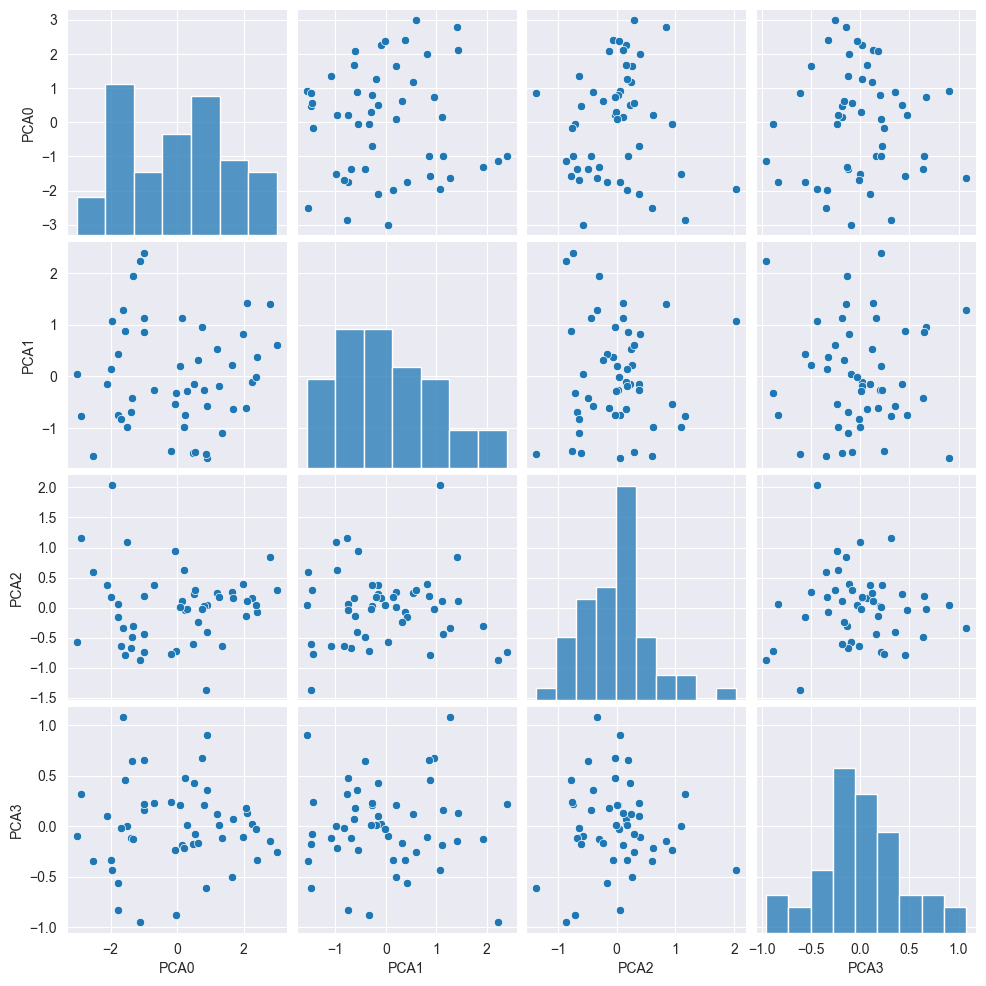

In [73]:
sns.pairplot(usarrests_pca_df.iloc[:, 1:])

What do the principal axes look like?

In [49]:
pca_vec_df = pd.DataFrame(
    w_t_mat.T,
    index=usarrests_data_df.columns,
    columns=[f"PCA{i}" for i in range(s_mat.shape[0])]
)
pca_vec_df.head()

,PCA0,PCA1,PCA2,PCA3
Murder,-0.535900,0.418181,-0.341233,0.649228
Assault,-0.583184,0.187986,-0.268148,-0.743407
UrbanPop,-0.278191,-0.872806,-0.378016,0.133878
Rape,-0.543432,-0.167319,0.817778,0.089024


We see that for the first component, "Murder", "Assault", and "Rape" are mostly the same magnitude as expected from our pair plots. When we examine the second component, we see that the "UrbanPop" observable is largely orthogonal to the other observables with some co-linearity with "Murder".

Let's add state labels to the PCA components.

In [66]:
def plot_pca_pair(n1, n2):
    x_name = "PCA" + str(n1)
    y_name = "PCA" + str(n2)

    output_file(
        Path(f"pca_plots/pca{str(n1)+str(n2)}.html"),
        title=f"PCA{str(n1)+str(n2)} Scatter"
    )

    pca_fig = figure(
        x_range=tuple(1.1 * np.array([np.min(usarrests_pca[:, n1]), np.max(usarrests_pca[:, n1])])),
        y_range=tuple(1.1 * np.array([np.min(usarrests_pca[:, n2]), np.max(usarrests_pca[:, n2])])),
    )

    pca_fig.scatter(
        x=x_name,
        y=y_name,
        source=usarrests_pca_df,
        size=8
    )

    pca_fig.xaxis.axis_label = x_name
    pca_fig.yaxis.axis_label = y_name
    pca_fig_labels = LabelSet(
        x=x_name,
        y=y_name,
        text="State",
        x_offset=5,
        y_offset=5,
        source=ColumnDataSource(usarrests_pca_df),
    )

    pca_fig.add_layout(pca_fig_labels)
    show(pca_fig)
    save(pca_fig)


In [67]:
plot_pca_pair(0, 1)

I see two clusters separated broken by PCA0 $\approx 0$.

In [74]:
plot_pca_pair(0, 2)

I see two clusters again and they narrow now.

In [75]:
plot_pca_pair(1, 2)

The data separation or also the explanation of variance is declining.

In [36]:
plot_pca_pair(2, 3)

Now we see almost no correlation. For the last two components, the data is quite clustered in the neighborhood of |PCA2,PCA3|$<0.5$

Let's calculate the percentage of variance explained by the PCA transformation

The equation I am using is given from "An Introduction to Statistical Learning" by James et al.

$$
\begin{align}
    \text{PVE}_c &= \frac{\sum_{i=1}^n \left(\sum_{j=1}^p W_{cj} M_{ij} \right)^2}{\sum_{i^{\prime}=1}^n \sum_{j^{\prime}=1}^p \left( M_{ij} \right)^2}\\
\end{align}
$$

the numerator (denominator) is the total variance explained by the PCA $c$ component vector (all data).

In [86]:
def variance_explained(comp: int) -> float:
    """Calculate the percentage of variance explained by the PCA basis

    :param comp: PCA component index
    :return: Percentage of variance
    """

    data_var, pca_var = 0., 0.
    for row in range(usarrests_pca.shape[0]):
        temp_pca = 0.
        for col in range(usarrests_pca.shape[1]):
            temp_pca += w_t_mat.T[col, comp] * data_norm_mat[row, col]
            data_var += data_norm_mat[row, col] ** 2
        pca_var += temp_pca ** 2
    return pca_var / data_var


In [90]:
var_cum = 0.
for comp in range(s_mat.shape[0]):
    pve = 100 * variance_explained(comp)
    var_cum += pve
    print(f"PVE {comp} (cum) = {pve:.2f}% ({var_cum}")


PVE 0 (cum) = 62.01% (62.00606602356679
PVE 1 (cum) = 24.74% (86.75020531688594
PVE 2 (cum) = 8.91% (95.66428577216335
PVE 3 (cum) = 4.34% (100.0000379823021


So we can say that the first three components account for 95% of all variance!

Let's export the data for another notebook.

In [41]:
usarrests_pca_df[new_column_ordering].to_csv(
    Path("usarrests_pca.csv"),
    index=False,
)